## Modelo Hierarchical Clustering

### Importamos Librerias necesarias para tratar datos, realizar graficos y crear modelo Hierarchical Clustering

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Librerias para implementar modelo Hierarchical
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler #Escalar o normalizar datos
from scipy.cluster.hierarchy import linkage, dendrogram
#Librerias para evaluar el modelo
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
#Libreria para evitar la advertencia de que el modelo tiene perdida de memoria
import warnings

### Análisis Exploratorio de Datos

In [16]:
warnings.filterwarnings('ignore')

# Cargar los datos en un dataframe
data= pd.read_csv('Mall_Customers.csv')

In [18]:
# Visualizar los primeros 2o registros
print(data.head(20))

    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0            1    Male   19                  15                      39
1            2    Male   21                  15                      81
2            3  Female   20                  16                       6
3            4  Female   23                  16                      77
4            5  Female   31                  17                      40
5            6  Female   22                  17                      76
6            7  Female   35                  18                       6
7            8  Female   23                  18                      94
8            9    Male   64                  19                       3
9           10  Female   30                  19                      72
10          11    Male   67                  19                      14
11          12  Female   35                  19                      99
12          13  Female   58                  20                 

In [20]:
# Obtener medidas de tendecia central, cuartiles, min y max
print(data.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [22]:
# Verificar nombre y tipo de dato de las columnas
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [24]:
# Verificar valores nulos
print(data.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [29]:
# Utilizar one-hot-encoding para tratar la variable categorica
data=pd.get_dummies(data, columns=['Gender'], drop_first=True)

Aplicamos el metodo de get_dumies a la variable 'Gender', ya que el rendimiento del modelo se ve afectado con variables categóricas, de esta forma se crea un nueva columna 'Gender_Male' la cual es de tipo booleano

In [31]:
# Verificar primeros 15 regsitros después de las modificaciones
print(data.head(15))

    CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0            1   19                  15                      39         True
1            2   21                  15                      81         True
2            3   20                  16                       6        False
3            4   23                  16                      77        False
4            5   31                  17                      40        False
5            6   22                  17                      76        False
6            7   35                  18                       6        False
7            8   23                  18                      94        False
8            9   64                  19                       3         True
9           10   30                  19                      72        False
10          11   67                  19                      14         True
11          12   35                  19                      99        False

### Verificar Datos Atípicos

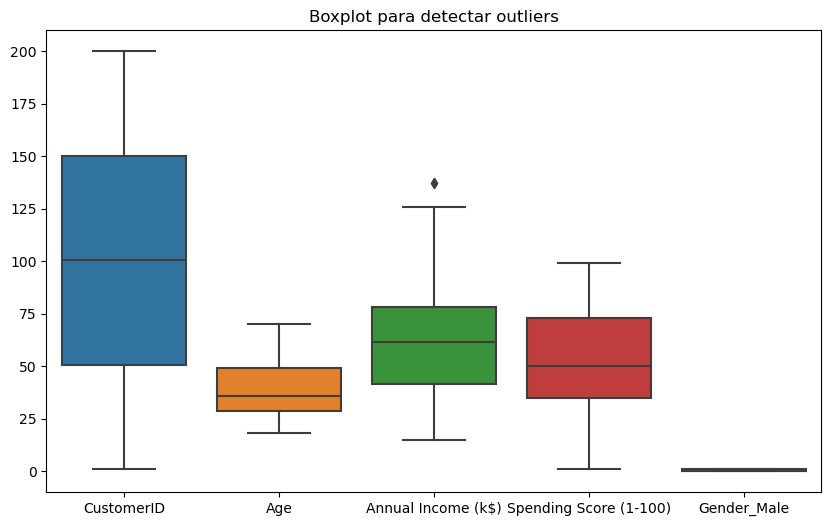

In [33]:
# Grafico para detectar valores atipicos
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('Boxplot para detectar outliers')
plt.show()

Observamos que la variable 'Annual Income (k$)' tiene valores atipicos pero esa cantidad cantidad es muy baja lo cual no afectara el modelo

### Seleccionar mejores Características

In [35]:
#Filtrar mejores caracteristicas del modelo
datos= data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']]

#Revisar los datos de las caracteristicas seleccionadas
print(datos.head(15))

    Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0    19                  15                      39         True
1    21                  15                      81         True
2    20                  16                       6        False
3    23                  16                      77        False
4    31                  17                      40        False
5    22                  17                      76        False
6    35                  18                       6        False
7    23                  18                      94        False
8    64                  19                       3         True
9    30                  19                      72        False
10   67                  19                      14         True
11   35                  19                      99        False
12   58                  20                      15        False
13   24                  20                      77        False
14   37                  

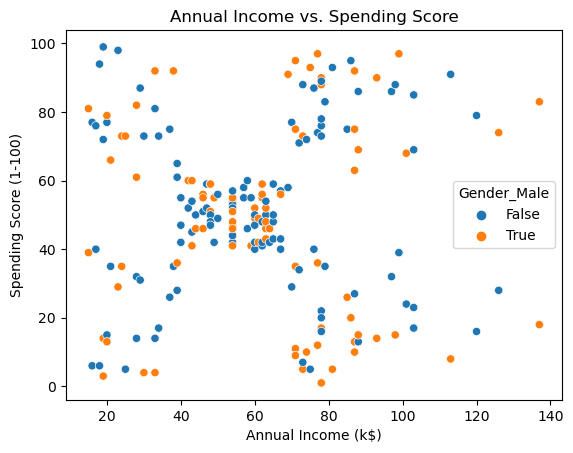

In [37]:
#Grafica antes del agrupamiento
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=datos, hue='Gender_Male' )
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Annual Income vs. Spending Score')
plt.show()

### Análisis Gráfico

Distribución general: Los puntos están distribuidos en todo el rango de ingreso anual de 0 a 140k y de puntuación de gasto de 0 a 100. Hay agrupaciones de puntos alrededor de ciertos niveles de ingreso y puntuación, lo que podría indicar la existencia de patrones o segmentos específicos de consumidores.

Diferencias de género: Ambos géneros parecen estar presentes en todos los niveles de ingreso y puntuación de gasto, aunque podría haber áreas donde un género se concentre más que el otro. No parece haber una diferencia clara en términos de ingresos anuales o puntuación de gasto que dependa del género.

Segmentación de clientes: Se pueden observar posibles grupos en ciertas áreas del gráfico. Por ejemplo, algunos puntos se concentran alrededor de ingresos anuales de entre 60k-80k con puntuaciones de gasto tanto altas como bajas. Hay un vacío notable en la parte superior izquierda (bajos ingresos y alta puntuación de gasto) y en la parte inferior derecha (altos ingresos y baja puntuación de gasto), lo que sugiere que es poco común que personas con bajos ingresos gasten mucho y viceversa.

In [39]:
#Escalar o estandarizar datos
scaler=StandardScaler()
data_scaled= scaler.fit_transform(datos[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']])

In [44]:
#Reemplazar valores NaN, inf y -inf
data_scaled=np.nan_to_num(data_scaled)

#Continuar con Hierarchical Clustering
linked= linkage(data_scaled, method='ward')

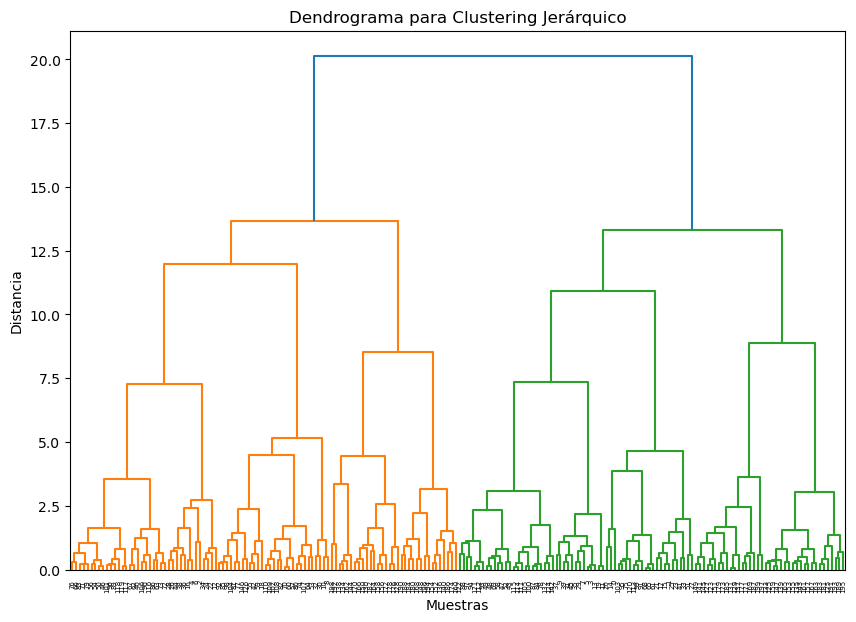

In [46]:
#Graficar el dedograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrograma para Clustering Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

### Análisis Gráfico

Las ramas del dendrograma indican las uniones de las muestras en distintos niveles. Por ejemplo, las ramas de color naranja y verde muestran dos grandes grupos que se dividen a su vez en subgrupos más pequeños.

#### Grupo Naranja: 
Un conjunto de muestras se agrupa de manera distinta a las del grupo verde, indicando que tienen características más similares entre sí.
#### Grupo Verde: 
Otro conjunto de muestras con características similares, pero diferentes a las del grupo naranja.

#### Formación de Grupos: 
Las variables numéricas (Age, Annual Income, Spending Score) pueden influir en la formación de los clusters debido a sus valores continuos, lo cual permite medir la similitud o disimilitud entre los datos.

#### Interpretación de Clusters: 
Al analizar el dendrograma, se puede puede observar que los grupos formados están basados en patrones de gasto similares, niveles de ingreso o rangos de edad. Por ejemplo, es posible que un cluster agrupe a personas jóvenes con un ingreso anual bajo y un puntaje de gasto alto.


### Crear Modelo 

In [48]:
#Entrenamiento del Modelo Clustering jerarquico 
# se utilizan 12 clusteres por un modelo más optimo
# respecto a otros resultados no tan favorables obtenidos con otro numero de clusters
model= AgglomerativeClustering(n_clusters=12, linkage='ward')
labels= model.fit_predict(data_scaled)


### Obtener Resultados de las Metricas

In [52]:
#Evaluacion del Modelo
#Coeficiente del Silhoutte
sil_score= silhouette_score(data_scaled, labels)
print(f"Coeficiente de Silhouette: {sil_score}")

#Indice de Calinski-Harabasz
ch_score= calinski_harabasz_score(data_scaled, labels)
print(f"Coeficiente de Calinski-Harabasz: {ch_score}")

#Indice de Davies-Boulding
dv_score= davies_bouldin_score(data_scaled, labels)
print(f"Coeficiente de Davies-Boulding: {dv_score}")

#Aplicar modelo de clustering jerarquico
datos['Cluster']= model.fit_predict(data_scaled)

Coeficiente de Silhouette: 0.4244032430367754
Coeficiente de Calinski-Harabasz: 87.02394354034617
Coeficiente de Davies-Boulding: 0.823210932728164


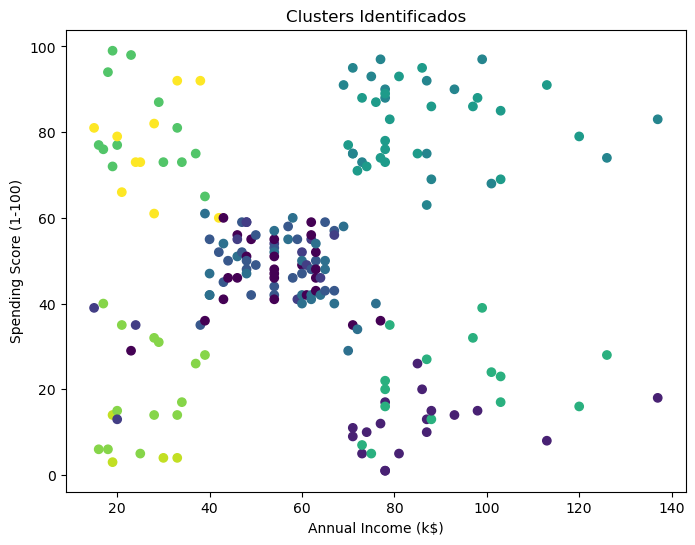

In [54]:
#Graficar clusters
plt.figure(figsize=(8, 6))
plt.scatter(datos['Annual Income (k$)'], datos['Spending Score (1-100)'], c=datos['Cluster'], cmap='viridis')
plt.title('Clusters Identificados')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


### Análsis Gráfico

#### Interpretación de Clusters:

#### Cluster con Ingreso Bajo y Puntaje de Gasto Alto (Esquina superior izquierda):

Este grupo podría representar personas con ingresos bajos pero un alto nivel de gasto, posiblemente jóvenes que gastan en actividades de ocio.

#### Cluster con Ingreso Alto y Puntaje de Gasto Alto (Esquina superior derecha):

Podría representar a individuos con alto poder adquisitivo que también tienen un comportamiento de gasto elevado.

#### Cluster con Ingreso Medio y Puntaje de Gasto Medio (Centro del gráfico):

Representa a personas con un ingreso promedio y un nivel de gasto moderado.

#### Cluster con Ingreso Alto y Puntaje de Gasto Bajo (Esquina inferior derecha): 

Indica personas que tienen un ingreso alto pero un bajo nivel de gasto, lo que podría corresponder a individuos más ahorradores o con un enfoque diferente de consumo.

#### Densidad de Clusters:

Se nota una alta densidad de puntos en el centro del gráfico, lo que indica que hay un grupo más numeroso de individuos con ingresos y puntajes de gasto promedio.
Clusters más pequeños en los extremos indican subgrupos específicos con comportamientos más particulares.



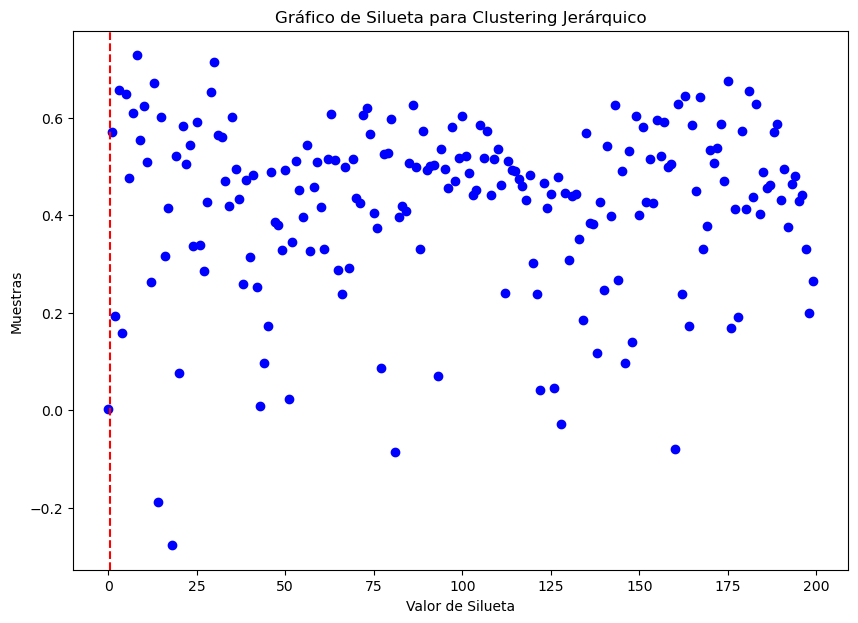

In [56]:
#Mostrar el grafico de silueta para Clustering Jerarquico
sample_silhouette_values = silhouette_samples(data_scaled, model.labels_)
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(sample_silhouette_values, 'bo')
ax.axvline(x=sil_score, color="red", linestyle="--")
ax.set_title("Gráfico de Silueta para Clustering Jerárquico")
ax.set_xlabel("Valor de Silueta")
ax.set_ylabel("Muestras")
plt.show()

### Análsis de Resultados

#### Coeficiente de Silhouette (0.424): 

Este coeficiente varía entre -1 y 1, donde un valor más cercano a 1 indica que los puntos están bien agrupados y claramente separados de otros clústeres. Un valor de 0.424 indica que el modelo tiene una calidad de agrupación moderada; los clústeres están definidos, pero podrían no ser perfectamente compactos ni estar claramente separados.

#### Coeficiente de Calinski-Harabasz (87.02): 

Este índice mide la dispersión entre los clústeres y dentro de ellos. Cuanto mayor es el valor, mejor es la separación entre los clústeres. Un valor de 87.02 es un indicador de que el modelo tiene una estructura razonable, pero se podría considerar si aumentar el número de clústeres mejora esta métrica.

#### Coeficiente de Davies-Bouldin (0.823): 

Este índice busca valores bajos, ya que representa la media de la máxima semejanza entre cada clúster y el más similar a él. Un valor de 0.823 indica que los clústeres tienen una calidad aceptable, pero existe una cierta cercanía entre algunos de ellos.

### Análisis Gráfico

Valores cercanos a 1: Indican que la muestra está bien agrupada y es similar a las otras muestras de su cluster.
Valores cercanos a 0: Sugieren que la muestra está en la frontera de dos clusters, sin una clara asignación a uno específico.
Valores negativos: Indican que la muestra podría haberse asignado a un cluster incorrecto, ya que es más parecida a los puntos de otro cluster.

#### Distribución de Valores:

La mayoría de los puntos se encuentran por encima de 0, lo que indica que las muestras están bien agrupadas en sus respectivos clusters.
Sin embargo, hay algunos puntos con valores negativos, lo que significa que esas muestras podrían estar mejor en otro cluster.

#### Calidad del Clustering:

Si bien muchos puntos tienen un valor de silueta razonablemente alto (cercano a 0.5 o superior), la presencia de algunos puntos negativos y valores bajos sugiere que hay áreas de mejora en la asignación de clusters.
Un valor de silueta promedio mayor a 0.5 suele considerarse una buena agrupación, mientras que un valor entre 0.25 y 0.5 indica una estructura moderada de clusters. Si hay muchos valores por debajo de 0, es señal de que el modelo puede no estar identificando adecuadamente algunos clusters.